In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline
import torch
from torch.nn import MSELoss
from torchvision import transforms
from PIL import Image
from monai.networks.blocks import Warp
from monai.networks.nets import GlobalNet
import numpy as np

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
!unzip -qq /content/drive/MyDrive/MRI_data/2Dt_10000.zip;

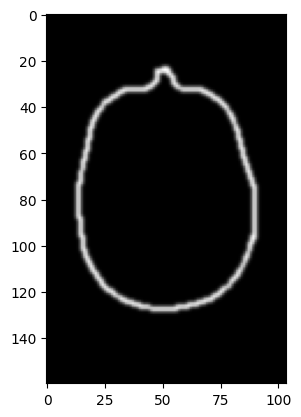

In [ ]:
import matplotlib.pyplot as plt
fixed = Image.open('/content/fixed_image0.png')
fixed = fixed.crop((48, 64, 152, 224)) #cropping to a more suitable size

#plt.figure("check", (12, 6))
plt.imshow(fixed, cmap="gray")

plt.show()

In [ ]:
n =  1001 #number of augmented images + 1
fixed = Image.open('/content/fixed_image0.png')
fixed = fixed.crop((48, 64, 152, 224)) #cropping to a more suitable size
convert_tensor = transforms.ToTensor()
fixed = convert_tensor(fixed)
fixed1 = fixed.unsqueeze(0)

list1 = []
for i in range (1,n):
  moving = Image.open(f'/content/train/00{i}_rt.png')
  moving = moving.crop((48, 64, 152, 224))
  moving = convert_tensor(moving)
  moving1 = moving.unsqueeze(0)
  list1.append(moving1)

#inputt = torch.cat((fixed, moving), dim=1)

In [ ]:
#translations parameters - x and y are swapped for these coordinates vs mri ones
translations_x = []
translations_y = []
#for fixed image?
#translations.append(0)
for i in range(1, n):
    with open(f"/content/train/00{i}_augments.txt") as f:
        lines = f.readlines()
        line1 = lines[0]
        ty = float(line1.split("=")[1])
        translations_y.append(ty)

        line2 = lines[1]
        tx = float(line2.split("=")[1])
        translations_x.append(tx)

In [ ]:
ddfs = []
for (tx, ty) in zip(translations_x, translations_y):
  image_width = 104
  image_height = 160

  # Create mesh grid
  x, y = np.meshgrid(range(image_width), range(image_height))

  # Initialize tensor
  displacement_field = np.zeros((image_height, image_width, 2))

  # Apply transformation parameters
  homogeneous_coordinates = np.stack([x.flatten(), y.flatten(), np.ones_like(x.flatten())])
  transformation_matrix = np.array([[1, 0, tx], [0, 1, ty]])
  transformed_homogeneous_coordinates = transformation_matrix @ homogeneous_coordinates

  # Compute displacement field
  displacement_field[..., 0] = transformed_homogeneous_coordinates[0].reshape((image_height, image_width)) - x
  displacement_field[..., 1] = transformed_homogeneous_coordinates[1].reshape((image_height, image_width)) - y

  displacementfield0 = torch.tensor(displacement_field)
  displacementfield = displacementfield0.unsqueeze(0)
  displacementfield = displacementfield.permute(0, 3, 1, 2)
  displacementfield.size()
  ddfs.append(displacementfield)

print(ddfs[1])

tensor([[[[ 3.6859,  3.6859,  3.6859,  ...,  3.6859,  3.6859,  3.6859],
          [ 3.6859,  3.6859,  3.6859,  ...,  3.6859,  3.6859,  3.6859],
          [ 3.6859,  3.6859,  3.6859,  ...,  3.6859,  3.6859,  3.6859],
          ...,
          [ 3.6859,  3.6859,  3.6859,  ...,  3.6859,  3.6859,  3.6859],
          [ 3.6859,  3.6859,  3.6859,  ...,  3.6859,  3.6859,  3.6859],
          [ 3.6859,  3.6859,  3.6859,  ...,  3.6859,  3.6859,  3.6859]],

         [[-2.8252, -2.8252, -2.8252,  ..., -2.8252, -2.8252, -2.8252],
          [-2.8252, -2.8252, -2.8252,  ..., -2.8252, -2.8252, -2.8252],
          [-2.8252, -2.8252, -2.8252,  ..., -2.8252, -2.8252, -2.8252],
          ...,
          [-2.8252, -2.8252, -2.8252,  ..., -2.8252, -2.8252, -2.8252],
          [-2.8252, -2.8252, -2.8252,  ..., -2.8252, -2.8252, -2.8252],
          [-2.8252, -2.8252, -2.8252,  ..., -2.8252, -2.8252, -2.8252]]]],
       dtype=torch.float64)


In [ ]:
activation = {}


def get_activation(name):
    def hook(net, input, output):
        activation[name] = output.detach()

    return hook

def custom_loss(result, displacementfield):
    return torch.mean((result - displacementfield)**2)

input_param = {
    "image_size": (160, 104),
    "spatial_dims": 2,
    "in_channels": 2,
    "num_channel_initial": 16,
    "depth": 3,
}
net = GlobalNet(**input_param)
net.output_block.fc.register_forward_hook(get_activation("fc"))
warp_layer = Warp()
image_loss = MSELoss()
optimizer = torch.optim.Adam(net.parameters(), 1e-5)
#optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
criterion = custom_loss

/usr/local/lib/python3.10/dist-packages/monai/networks/blocks/warp.py:67: UserWarning: monai.networks.blocks.Warp: Using PyTorch native grid_sample.
  warnings.warn("monai.networks.blocks.Warp: Using PyTorch native grid_sample.")


In [ ]:
#net.load_state_dict(torch.load('/content/drive/MyDrive/MRI_data/2trans.pth'))
#net.eval()

In [ ]:
max_epochs = 30
epoch_loss_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    net.train()
    epoch_loss, step = 0, 0
    for (moving1, displacementfield) in zip(list1, ddfs):
        step += 1
        optimizer.zero_grad()
        result = net(torch.cat((fixed1, moving1), dim=1))
        pred_image = warp_layer(moving1, result)
        #print(activation)
        #loss = image_loss(pred_image, fixed1)
        #loss = criterion(activation['fc'], translation)
        loss = criterion(result, displacementfield)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

----------
epoch 1/30
epoch 1 average loss: 61.8732
----------
epoch 2/30
epoch 2 average loss: 30.3600
----------
epoch 3/30
epoch 3 average loss: 21.5073
----------
epoch 4/30
epoch 4 average loss: 13.2311
----------
epoch 5/30
epoch 5 average loss: 13.0845
----------
epoch 6/30
epoch 6 average loss: 7.1476
----------
epoch 7/30
epoch 7 average loss: 6.3521
----------
epoch 8/30
epoch 8 average loss: 5.7776
----------
epoch 9/30
epoch 9 average loss: 5.1592
----------
epoch 10/30
epoch 10 average loss: 4.5383
----------
epoch 11/30
epoch 11 average loss: 4.0592
----------
epoch 12/30
epoch 12 average loss: 3.4441
----------
epoch 13/30
epoch 13 average loss: 3.3086
----------
epoch 14/30
epoch 14 average loss: 2.9276
----------
epoch 15/30
epoch 15 average loss: 2.9975
----------
epoch 16/30
epoch 16 average loss: 2.5354
----------
epoch 17/30
epoch 17 average loss: 2.7578
----------
epoch 18/30
epoch 18 average loss: 2.3718
----------
epoch 19/30
epoch 19 average loss: 2.3457
------

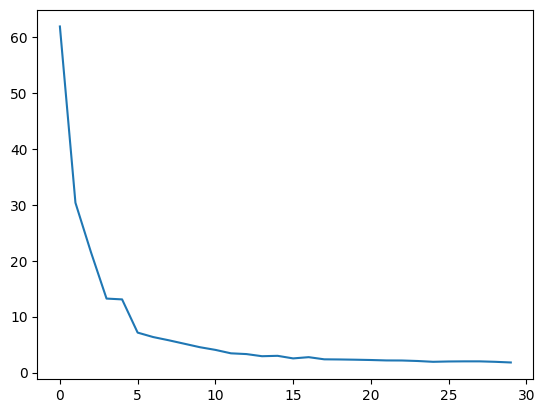

In [ ]:
%matplotlib inline
plt.plot(epoch_loss_values)

Now with validation data

In [ ]:
m = 101 #number of test data

list2 = []
for i in range (1,m):
  moving = Image.open(f'/content/test/00{i}_rt.png')
  moving = moving.crop((48, 64, 152, 224))
  moving = convert_tensor(moving)
  moving2 = moving.unsqueeze(0)
  list2.append(moving2)

In [ ]:
activations = []
for moving2 in list2:
    ddf = net(torch.cat((moving2, fixed1), dim=1))
    #pred_image = warp_layer(moving2, ddf)
    print(activation)
    #pred_image = pred_image.detach().cpu().numpy()[:, 0]
    activations.append(activation['fc'])

#activations[10]['fc'][0,2].item()

{'fc': tensor([[ 1.0175,  0.0145, -1.7593, -0.0331,  0.9881,  4.3944]])}
{'fc': tensor([[ 1.0093,  0.0056, -1.4601, -0.0241,  0.9864,  2.8390]])}
{'fc': tensor([[ 0.9958, -0.0033,  0.8432,  0.0086,  1.0035, -1.6480]])}
{'fc': tensor([[ 1.0024e+00,  2.1662e-03, -8.2321e-01, -1.6854e-02,  9.9188e-01,
          2.2860e+00]])}
{'fc': tensor([[ 1.0081e+00, -9.1370e-04, -1.9528e+00, -2.2148e-02,  9.8604e-01,
          2.6468e+00]])}
{'fc': tensor([[ 1.0024e+00,  2.1662e-03, -8.2321e-01, -1.6854e-02,  9.9188e-01,
          2.2860e+00]])}
{'fc': tensor([[ 0.9982, -0.0064, -0.2900, -0.0038,  0.9943, -0.1603]])}
{'fc': tensor([[ 1.0004,  0.0066,  0.6455, -0.0078,  0.9976,  0.8050]])}
{'fc': tensor([[ 9.9825e-01,  4.6557e-04,  7.5621e-01,  5.6012e-03,  1.0038e+00,
         -9.7317e-01]])}
{'fc': tensor([[ 0.9942,  0.0044,  2.7936,  0.0264,  1.0114, -4.0750]])}
{'fc': tensor([[ 1.0002e+00, -5.1543e-04,  3.0031e-02, -5.6557e-04,  9.9970e-01,
          1.1862e-02]])}
{'fc': tensor([[ 1.0036e+00, -1.

In [ ]:
predx = []

for activation in activations:
  a = activation[0,2].item()
  predx.append(a)
print(predx)

predy = []

for activation in activations:
  b = activation[0,5].item()
  predy.append(b)
print(predy)

[-1.7592766284942627, -1.460071325302124, 0.8432220220565796, -0.8232071995735168, -1.952776312828064, -0.8232071995735168, -0.2900068163871765, 0.6455438733100891, 0.7562134265899658, 2.7936065196990967, 0.030030816793441772, -1.2433562278747559, 0.030030816793441772, -0.5465821027755737, -0.2900068163871765, 1.7017120122909546, 0.030030816793441772, -0.159845232963562, -0.4289197325706482, -1.460071325302124, -1.171871304512024, 0.030030816793441772, -0.8232071995735168, 0.8432220220565796, -1.171871304512024, -0.10005737841129303, -0.4289197325706482, -0.6843411922454834, 0.7562134265899658, 1.2078317403793335, 1.2078317403793335, 1.3295300006866455, -1.460071325302124, -0.4289197325706482, 1.8801515102386475, 0.22243943810462952, 0.7562134265899658, -1.1614596843719482, -0.5465821027755737, 0.030030816793441772, 1.8510489463806152, 1.2078317403793335, -0.5465821027755737, 1.3295300006866455, 0.11420520395040512, -0.10005737841129303, -1.460071325302124, 1.7386994361877441, 0.843222

In [ ]:
#translations parameters for test data
#y:
test_x = []
test_y = []
for i in range(1, m):
    with open(f"/content/test/00{i}_augments.txt") as f:
        lines = f.readlines()
        line1 = lines[1]
        t1 = float(line1.split("=")[1])
        test_x.append(t1)
        line2 = lines[0]
        t2 = float(line2.split("=")[1])
        test_y.append(t2)

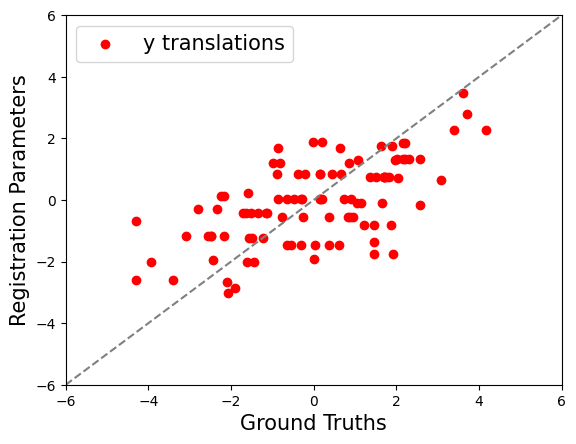

In [ ]:
%matplotlib inline
plt.scatter(test_x, predx, label="y translations", color='red')
# set the x and y axis labels
plt.xlabel("Ground Truths", fontsize = 15)
plt.ylabel("Registration Parameters", fontsize = 15)
plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.legend(fontsize=15, loc='upper left')

plt.plot([-6, 6], [-6, 6], linestyle='--', color='gray')


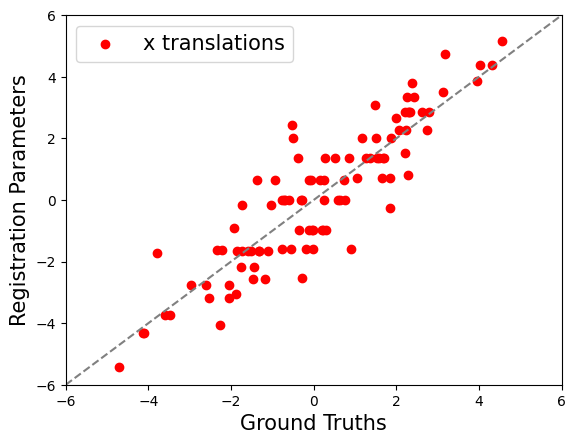

In [ ]:
%matplotlib inline
plt.scatter(test_y, predy, label="x translations", color='red')
# set the x and y axis labels
plt.xlabel("Ground Truths", fontsize = 15)
plt.ylabel("Registration Parameters", fontsize = 15)
plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.legend(fontsize=15, loc='upper left')

plt.plot([-6, 6], [-6, 6], linestyle='--', color='gray')


In [ ]:
torch.save(net.state_dict(), '/content/drive/MyDrive/MRI_data/2trans_30.pth')